## Project Overview: Training an Image Classifier for Flower Species

In this project, I’ll be building an **image classifier** to recognize different species of flowers. To do this, I’ll train the classifier, fine-tune it, and then export it for use in an application.


### Dataset ###
- I’ll be working with the [102 Category Flower Dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html), which contains images of flowers from 102 unique categories.
- The dataset should already be included with this notebook, but if it’s missing, it can be [downloaded here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz).

 Below is an example from the dataset:

<img src='assets/Flowers.png' width=500px>

### Steps I'll Follow

I’ll break the project into the following steps:

1. **Load and preprocess the image dataset**  
   I’ll prepare the dataset for training by resizing, normalizing, and augmenting the images.

2. **Train the image classifier**  
   I’ll build and train a neural network model to recognize different flower species using the preprocessed dataset.

3. **Make predictions with the trained classifier**  
   Once trained, I’ll use the model to predict the species of flowers from new images.


### What I Aim to Achieve

When I’m done, I’ll have a functional application that can be trained on any set of labeled images. While I’m focusing on flowers here, I can apply the same skills to other datasets. 

In [2]:
# Imports here
import os
import matplotlib.pyplot as plt
import torch
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.models import VGG16_Weights
from PIL import Image
import numpy as np

## Data Loading and Preprocessing

To handle the dataset, I’ll use `torchvision` for loading and transforming the data. The dataset should already be included with this notebook, but if it’s missing, it can be [downloaded here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz).

The dataset is organized into three parts: **training**, **validation**, and **testing**. Here’s how I’ll preprocess each part:

### Training Data
For the training set, I’ll apply data augmentation techniques such as:
- **Random scaling**: Adjusting the size of the images randomly.
- **Cropping**: Taking random crops from the images.
- **Flipping**: Applying random horizontal flips.

These transformations will help the network generalize better by introducing variety in the input data. Additionally, all images will be resized to **224x224 pixels**, the required input size for the pre-trained networks.

### Validation and Testing Data
The validation and testing sets will be used to evaluate the model's performance on unseen data. For these sets, I won’t apply random transformations like scaling or flipping. Instead, I’ll:
- Resize the images.
- Center-crop them to **224x224 pixels**.

### Normalization
The pre-trained networks I’ll be using were trained on the **ImageNet dataset**, where each color channel was normalized individually. To match the network’s expectations, I’ll normalize all three datasets (training, validation, and testing) using the following values:
- **Means**: `[0.485, 0.456, 0.406]`
- **Standard deviations**: `[0.229, 0.224, 0.225]`

This normalization centers each color channel at 0 and scales the values to range between -1 and 1. It ensures that the input data aligns with the pre-trained network’s parameters, improving the model's performance.


In [4]:
data_dir = 'flower_data'
train_dir = os.path.join(data_dir, "train")
valid_dir = os.path.join(data_dir, "valid")
test_dir = os.path.join(data_dir, "test")

In [5]:
# Define your transforms for the training, validation, and testing sets
train_transform =  transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

valid_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224), 
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

# Load the datasets with ImageFolder
train_dataset = datasets.ImageFolder( train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder( valid_dir, transform=valid_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)

# Using the image datasets and the transform, define the dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [7]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [9]:
# Build and train your network
# Load the pretrained model
model = models.vgg16(weights=VGG16_Weights.DEFAULT)

# freeze parameters to avoid updating them during training
for param in model.parameters():
    param.requires_grad = False

In [10]:
# Define the new classifier
classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(4096, 1024),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(1024,102),
    nn.LogSoftmax(dim=1)
)

# Replacing the classifier in the model
model.classifier = classifier


In [11]:
#Define the loss function and optimizer
learning_rate = 0.001
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=learning_rate)

In [12]:
def validation(model, loader, criterion):
    """
        validation of model against test/validation data
    """
    model.eval()  # Set model to evaluation mode
    loss = 0
    accuracy = 0
    with torch.no_grad():  # Disable gradient calculations for validation
        for images, labels in loader:

            output = model(images)
            loss += criterion(output, labels).item()

            # Calculate accuracy
            ps = torch.exp(output)
            top_class = ps.topk(1, dim=1)[1]
            equals = top_class == labels.view(*top_class.shape)
            accuracy += equals.float().mean().item()
            
    # calculate average loss and accuracy
    loss = loss/len(loader)
    accuracy = accuracy/len(loader)
    
    return loss, accuracy

In [13]:
## Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

epochs = 3
for epoch in range(epochs):
    model.train()
    running_loss = 0

    # Training Loop
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # clear the gradients
        optimizer.zero_grad()

        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    # Validation loop
    val_loss, val_accuracy = validation(model, val_loader, criterion )

    print(f"Epoch {epoch+1}/{epochs}.. "
          f"Training Loss: {running_loss/len(train_loader):.3f}.. "
          f"Validation Loss: {val_loss:.3f}.. "
          f"Validation Accuracy: {val_accuracy*100:.2f}%")

Epoch 1/3.. Training Loss: 3.073.. Validation Loss: 1.086.. Validation Accuracy: 69.26%
Epoch 2/3.. Training Loss: 1.280.. Validation Loss: 0.636.. Validation Accuracy: 83.04%
Epoch 3/3.. Training Loss: 0.985.. Validation Loss: 0.488.. Validation Accuracy: 85.60%


## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [15]:
test_loss, test_accuracy = validation(model, test_loader, criterion )

print(f"Test Loss: {test_loss:.3f}.. "
      f"Test Accuracy: {test_accuracy*100:.2f}%")

Test Loss: 0.654.. Test Accuracy: 82.53%


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [17]:
# Save the checkpoint 
checkpoint = {
        'input_size': 25088,
        'output_size': 102,
        'epochs': epochs,
        'learning_rate': learning_rate,
        'classifier': model.classifier,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'class_to_idx': train_dataset.class_to_idx
    }
torch.save(checkpoint, 'model_checkpoint.pth')

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [19]:
# Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint(filepath):
    """
    Load a checkpoint and rebuild model
    """
    checkpoint = torch.load(filepath, weights_only=False)
    output_size = checkpoint['output_size']
    state_dict = checkpoint['model_state_dict']
    class_to_idx = checkpoint['class_to_idx']
    classifier = checkpoint['classifier']
    
    model = models.vgg16(weights=VGG16_Weights.DEFAULT)

    # freeze parameters to avoid updating them during training
    for param in model.parameters():
        param.requires_grad = False

    # Replacing the classifier in the model
    model.classifier = classifier
    model.load_state_dict( state_dict)
    model.class_to_idx = class_to_idx

    model.eval()

    return model

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [21]:


def process_image(image_path):
    """ 
    Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    """
    
    # Process a PIL image for use in a PyTorch model
    pil_image = Image.open(image_path)
    
    # Resize the image where the shortest side is 256 pixels
    aspect_ratio = pil_image.width / pil_image.height
   
    if pil_image.width < pil_image.height:
        new_size = (256, int(256 / aspect_ratio))
    else:
        new_size = (int(256 * aspect_ratio), 256)
    
    pil_image = pil_image.resize(new_size)
    
    # Crop the center 224x224 portion
    left = (pil_image.width - 224) / 2
    top = (pil_image.height - 224) / 2
    right = left + 224
    bottom = top + 224
    pil_image = pil_image.crop((left, top, right, bottom))
    
    # Convert to a numpy array and normalize
    np_image = np.array(pil_image) / 255.0
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_image = (np_image - mean) / std
    
    # Reorder dimensions to match PyTorch (C x H x W)
    np_image = np_image.transpose((2, 0, 1))
    
    # Convert to a tensor
    return torch.tensor(np_image, dtype=torch.float32)

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [23]:

def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [25]:
def predict(image_path, model, topk=5):
    """ 
        Predict the classes and probabilities of the classes of an image using a trained deep learning model.
    """
    # Process the image
    image = process_image(image_path)
    image = image.unsqueeze(0)  # Add batch dimension
    
    # Move the model and image to the appropriate device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    image = image.to(device)
    
    # Set the model to evaluation mode and make predictions
    model = load_checkpoint('model_checkpoint.pth')
    with torch.no_grad():
        output = model(image)
        probs, indices = torch.exp(output).topk(topk)
    
    # Convert tensors to lists and map indices to class labels
    # probs = probs.cpu().numpy().flatten().tolist()
    # indices = indices.cpu().numpy().flatten().tolist()
    probs = probs.squeeze().tolist()
    indices = indices.squeeze().tolist()
    # Map indices to class labels
    idx_to_class = {v: k for k, v in model.class_to_idx.items()}
    classes = [idx_to_class[idx] for idx in indices]
    
    return probs, classes

In [26]:
def plot_prediction(image_path, probs, classes, flower_names):

    """
    Plots the input image at the top and a bar chart of probabilities at the bottom.
    """

    fig, (ax1, ax2) = plt.subplots(figsize=(6, 9), nrows=2)
    ax1.axis('off')
    imshow(process_image(image_path), ax=ax1, title=flower_names[0])

    # Show the predictions
    y_pos = np.arange(len(flower_names))
    ax2.barh(y_pos, probs, align='center')
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(flower_names)
    ax2.invert_yaxis()  # Invert y-axis for better readability
    ax2.set_xlabel('Probability')
    
    plt.tight_layout()
    plt.show()


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

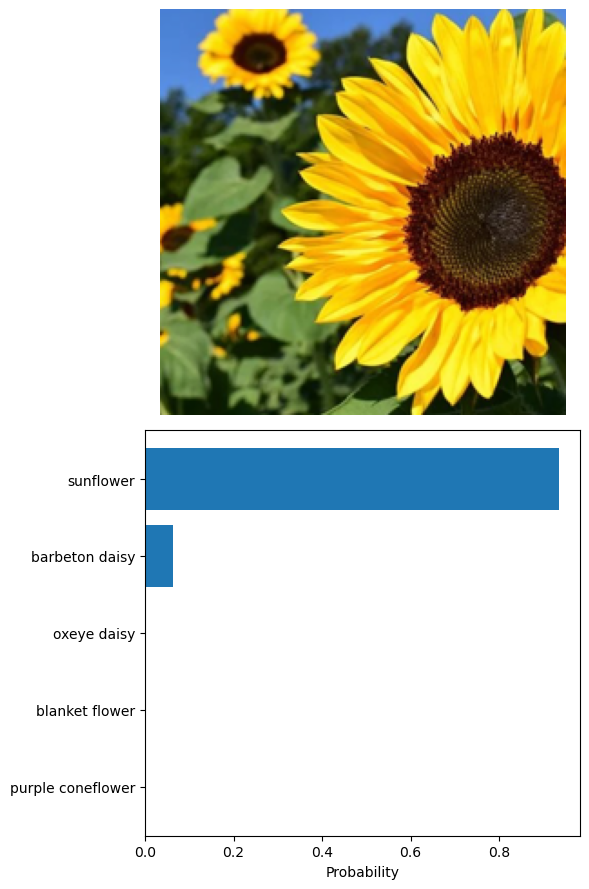

In [28]:
# Display an image along with the top 5 classes
image_path = 'flower_image.jpeg'
probs, classes = predict(image_path, model)
flower_names = [cat_to_name[str(cls)] for cls in classes]
plot_prediction(image_path, probs, classes, flower_names)